In [1]:
import duckdb
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

In [2]:
con = duckdb.connect("db_duckdb/balancacomercial.duckdb")
con.execute(""" ATTACH 'db_duckdb/cnpj.duckdb' AS cnpj (READ_ONLY)""")
con.execute(""" SHOW ALL TABLES""").df()

,database,schema,name,column_names,column_types,temporary
0,balancacomercial,main,dim_isic_cuci,"[CO_ISIC_SECAO, NO_ISIC_SECAO, CO_CUCI_GRUPO, ...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR]",False
1,balancacomercial,main,dim_nbm,"[CO_NBM, NO_NBM]","[VARCHAR, VARCHAR]",False
2,balancacomercial,main,dim_ncm,"[CO_NCM, CO_UNID, CO_SH6, CO_PPE, CO_PPI, CO_F...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR, VARCHAR, ...",False
3,balancacomercial,main,dim_ncm_fat_agreg,"[CO_FAT_AGREG, NO_FAT_AGREG, NO_FAT_AGREG_GP]","[VARCHAR, VARCHAR, VARCHAR]",False
4,balancacomercial,main,dim_ncm_ppe,"[CO_PPE, NO_PPE, NO_PPE_MIN, NO_PPE_ING]","[VARCHAR, VARCHAR, VARCHAR, VARCHAR]",False
5,balancacomercial,main,dim_ncm_ppi,"[CO_PPI, NO_PPI, NO_PPI_MIN, NO_PPI_ING]","[VARCHAR, VARCHAR, VARCHAR, VARCHAR]",False
6,balancacomercial,main,dim_ncm_unidade,"[CO_UNID, NO_UNID, SG_UNID]","[VARCHAR, VARCHAR, VARCHAR]",False
7,balancacomercial,main,dim_pais,"[CO_PAIS, CO_PAIS_ISON3, CO_PAIS_ISOA3, NO_PAI...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR, VARCHAR, ...",False
8,balancacomercial,main,dim_pais_bloco,"[CO_PAIS, CO_BLOCO, NO_BLOCO, NO_BLOCO_ING, NO...","[VARCHAR, VARCHAR, VARCHAR, VARCHAR, VARCHAR]",False
9,balancacomercial,main,dim_uf,"[SG_UF, CO_UF, NO_UF, NO_REGIAO]","[VARCHAR, VARCHAR, VARCHAR, VARCHAR]",False


In [3]:
con.execute(""" SELECT DISTINCT cnpj_basico, cnpj_ordem, cnpj_dv FROM cnpj.estabelecimentos """).df().shape[0]

18834781

10524625

-- ANÁLISE 1: POTENCIAL EXPORTADOR POR ESTADO (UF)

-- Pergunta: A quantidade de empresas ativas em um estado reflete o volume exportado?

In [16]:
con.execute(
"""
    SELECT 
        exp.SG_UF_NCM AS uf,
        SUM(exp.VL_FOB) AS total_exportado_usd,
        SUM(exp.KG_LIQUIDO) AS peso_liquido_kg
    FROM fct_exp_2021 exp
    GROUP BY exp.SG_UF_NCM
""").df().head()

,uf,total_exportado_usd,peso_liquido_kg
0,SP,"54,064,207,369.00","53,976,703,090.00"
1,MG,"38,340,190,460.00","164,930,118,298.00"
2,MA,"4,374,130,642.00","12,661,733,791.00"
3,DF,"268,627,645.00","225,009,684.00"
4,PR,"19,034,416,232.00","27,397,243,897.00"


In [8]:
con.execute(
"""
SELECT 
    est.uf,
    COUNT(*) AS qtd_empresas_ativas
FROM cnpj.estabelecimentos est
WHERE est.situacao_cadastral = '02' -- Filtra apenas empresas ATIVAS
GROUP BY est.uf

"""
).df().head()

,uf,qtd_empresas_ativas
0,PR,481940
1,RN,78083
2,AC,14240
3,RS,449517
4,CE,191166


In [9]:
df = con.execute(
"""
WITH exportacao_estado AS (
    SELECT 
        exp.SG_UF_NCM AS uf,
        SUM(exp.VL_FOB) AS total_exportado_usd,
        SUM(exp.KG_LIQUIDO) AS peso_liquido_kg
    FROM fct_exp_2021 exp
    GROUP BY exp.SG_UF_NCM
),
empresas_ativas_estado AS (
    SELECT 
        est.uf,
        COUNT(*) AS qtd_empresas_ativas
    FROM cnpj.estabelecimentos est
    WHERE est.situacao_cadastral = '02' -- Filtra apenas empresas ATIVAS
    GROUP BY est.uf
)
SELECT 
    ex.uf AS UF,
    e.qtd_empresas_ativas AS Qtd_Empresas_Ativas,
    CAST(ex.total_exportado_usd AS DECIMAL(18,2)) AS Total_Exportado_USD,
    CAST((ex.total_exportado_usd / e.qtd_empresas_ativas) AS DECIMAL(18,2)) AS USD_por_Empresa_Ativa
FROM exportacao_estado ex
JOIN empresas_ativas_estado e ON ex.uf = e.uf
ORDER BY USD_por_Empresa_Ativa DESC; """

).df()

In [10]:
df.head()

,UF,Qtd_Empresas_Ativas,Total_Exportado_USD,USD_por_Empresa_Ativa
0,PA,132170,"29,525,877,817.00","223,393.19"
1,MT,139939,"21,651,401,820.00","154,720.28"
2,MS,95728,"6,894,838,479.00","72,025.31"
3,ES,146308,"9,780,359,469.00","66,847.74"
4,RJ,587747,"33,293,630,291.00","56,646.19"


In [11]:
df["Total_Exportado_Bi"] = df["Total_Exportado_USD"] / 1000000000

In [14]:
df.head()

,UF,Qtd_Empresas_Ativas,Total_Exportado_USD,USD_por_Empresa_Ativa,Total_Exportado_Bi
0,PA,132170,"29,525,877,817.00","223,393.19",29.53
1,MT,139939,"21,651,401,820.00","154,720.28",21.65
2,MS,95728,"6,894,838,479.00","72,025.31",6.89
3,ES,146308,"9,780,359,469.00","66,847.74",9.78
4,RJ,587747,"33,293,630,291.00","56,646.19",33.29


/tmp/ipykernel_233779/3637517113.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


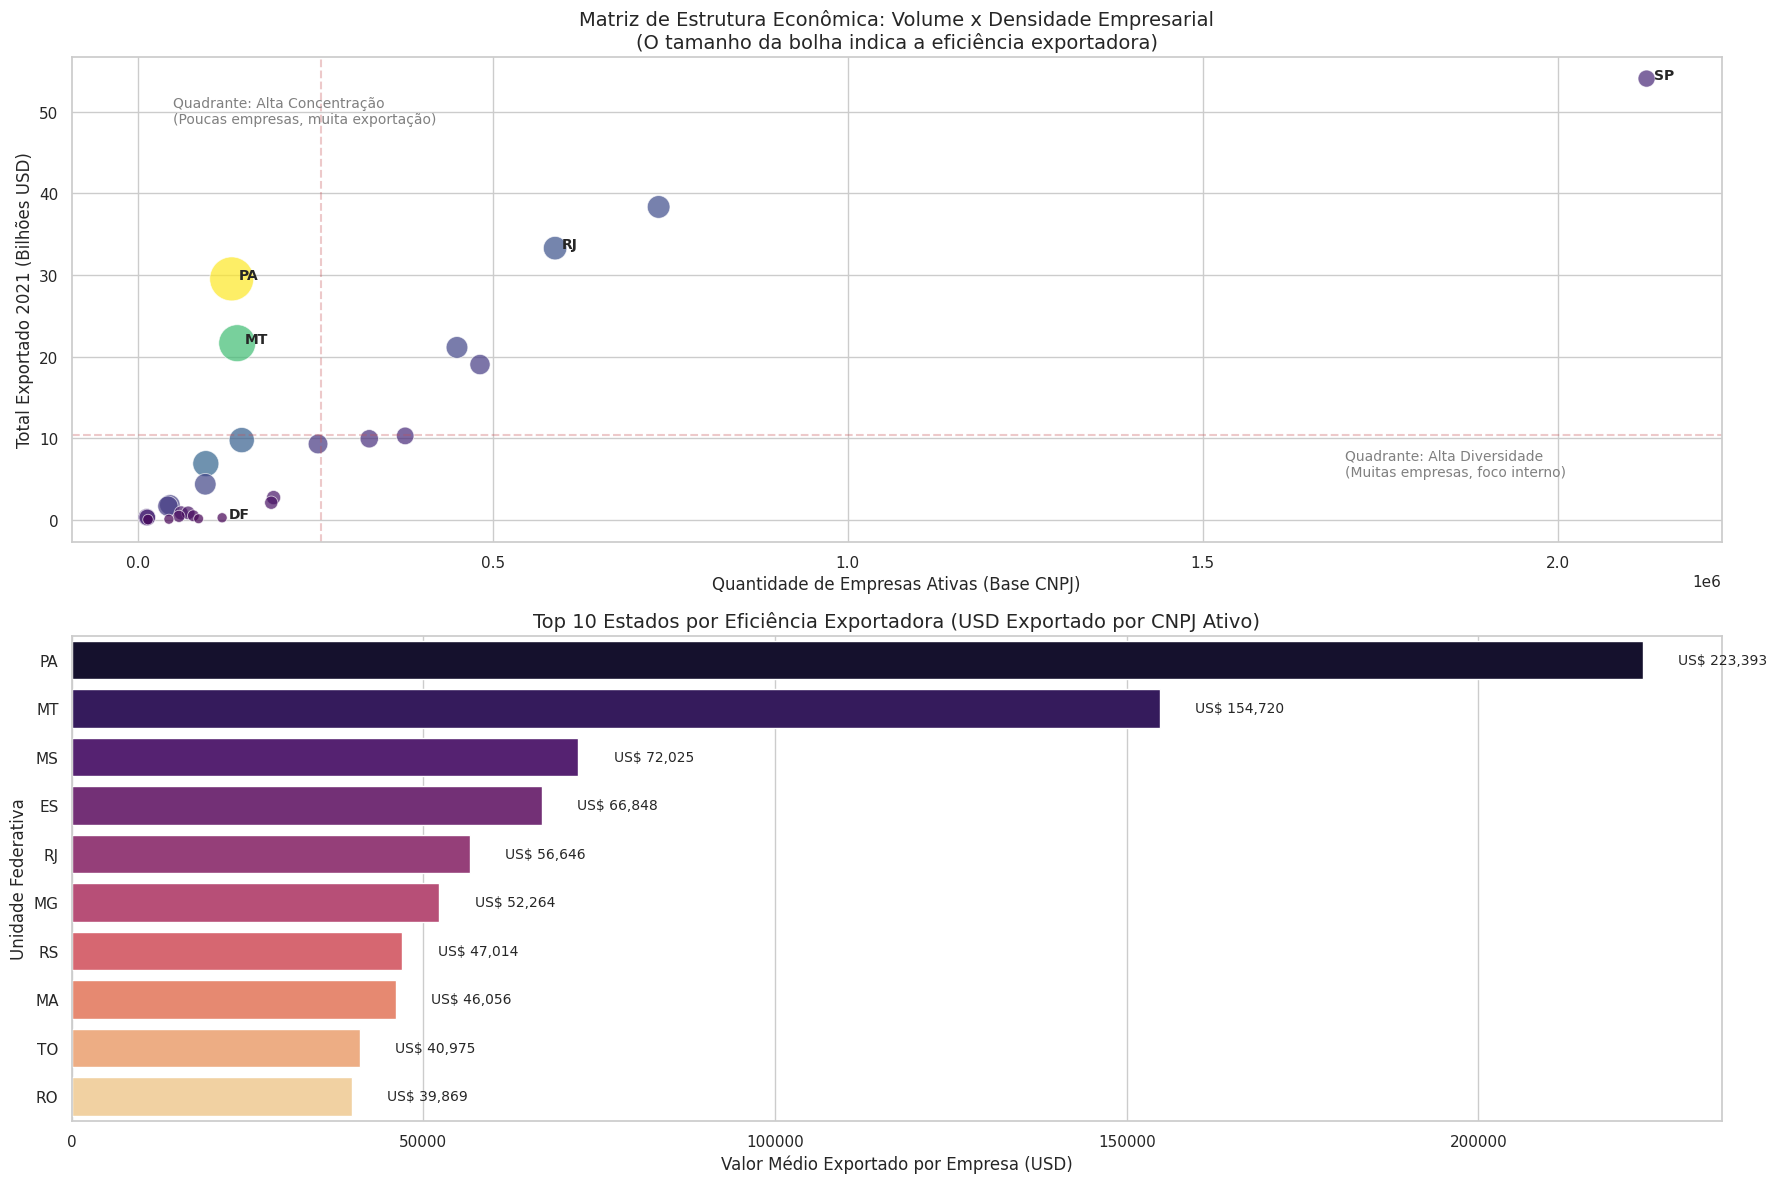

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Configuração de Estilo
sns.set_theme(style="whitegrid")
plt.figure(figsize=(18, 12))

# ---------------------------------------------------------
# VISUALIZAÇÃO 1: SCATTER PLOT (MATRIZ DE ESTRUTURA)
# ---------------------------------------------------------
plt.subplot(2, 1, 1) # Posição superior

# Scatter plot: X=Empresas, Y=Exportação, Tamanho=KPI
scatter = sns.scatterplot(
    data=df, 
    x='Qtd_Empresas_Ativas', 
    y='Total_Exportado_Bi', 
    size='USD_por_Empresa_Ativa', 
    sizes=(50, 1000), 
    hue='USD_por_Empresa_Ativa',
    palette='viridis', 
    alpha=0.7,
    legend=False
)

# Adicionando rótulos nos pontos
for i in range(df.shape[0]):
    # Destacar apenas os principais para não poluir
    if df.USD_por_Empresa_Ativa[i] > 100000 or df.UF[i] in ['SP', 'RJ', 'DF']:
        plt.text(
            df.Qtd_Empresas_Ativas[i]+10000, 
            df.Total_Exportado_Bi[i], 
            df.UF[i], 
            fontweight='bold', 
            size=10
        )

plt.title('Matriz de Estrutura Econômica: Volume x Densidade Empresarial\n(O tamanho da bolha indica a eficiência exportadora)', fontsize=14)
plt.xlabel('Quantidade de Empresas Ativas (Base CNPJ)', fontsize=12)
plt.ylabel('Total Exportado 2021 (Bilhões USD)', fontsize=12)

# Desenhando quadrantes teóricos (linhas médias)
plt.axhline(y=df['Total_Exportado_Bi'].mean(), color='r', linestyle='--', alpha=0.3)
plt.axvline(x=df['Qtd_Empresas_Ativas'].mean(), color='r', linestyle='--', alpha=0.3)
plt.text(df['Qtd_Empresas_Ativas'].max()*0.8, df['Total_Exportado_Bi'].max()*0.1, "Quadrante: Alta Diversidade\n(Muitas empresas, foco interno)", fontsize=10, color='gray')
plt.text(50000, df['Total_Exportado_Bi'].max()*0.9, "Quadrante: Alta Concentração\n(Poucas empresas, muita exportação)", fontsize=10, color='gray')


# ---------------------------------------------------------
# VISUALIZAÇÃO 2: RANKING DE KPI (QUEM É MAIS EFICIENTE?)
# ---------------------------------------------------------
plt.subplot(2, 1, 2) # Posição inferior

# Ordenar dados
df_sorted = df.sort_values('USD_por_Empresa_Ativa', ascending=False).head(10)

# Barplot
barplot = sns.barplot(
    data=df_sorted, 
    x='USD_por_Empresa_Ativa', 
    y='UF', 
    palette='magma'
)

# Adicionar valores nas barras
for index, value in enumerate(df_sorted['USD_por_Empresa_Ativa']):
    plt.text(value + 5000, index, f"US$ {value:,.0f}", va='center', fontsize=10)

plt.title('Top 10 Estados por Eficiência Exportadora (USD Exportado por CNPJ Ativo)', fontsize=14)
plt.xlabel('Valor Médio Exportado por Empresa (USD)', fontsize=12)
plt.ylabel('Unidade Federativa', fontsize=12)

plt.tight_layout()
plt.show()

- PA e MT: poucas empresas e muita exportação (commodite)
- SP exporta mais que todo mundo mas tem um numero elevado de empresas